# Chapter 7. Identifying Similar Groups in Data

In many applications, observations need to be divided into similar groups based on observed features. For example, retailers may want to divide potential customers into groups, in order to target a marketing campaign at the customers who are most likely to respond positively. This practice is known as **market segmentation**.

The general problem of grouping observations based on observed features is known as **clustering** in machine learning. Like the classification problems of Chapter 6, clustering is about dividing observations into categories based on features. Unlike classification, we do not have ground truth labels that specify what the categories should be; they have to be inferred from the data. In other words, with classification, the training data contains both features $X$ and labels $y$; with clustering, the training data only contains features $X$.

For this reason, clustering is an example of an **unsupervised learning** problem, in contrast to the **supervised learning** problems of the previous chapters. This terminology comes from the following analogy to human learning.  Imagine a child that is trying to learn the difference between shapes and has several examples of each shape in front of him.

<img src="shape_sorter.jpg" />

On the one hand, the child may be _supervised_ by an adult who gives the child feedback on each answer: "Yes, that is a circle....No, that was a square....No, that was actually a circle...."  This process is analogous to classification, where the labels in the training data can be used to evaluate how well the model is doing. Regression and classification are both examples of _supervised learning_ because labels are available in the training data.

On the other hand, the child may be _unsupervised_ and completely left to his own devices. Eventually, he may figure out that there is something similar about all of the circles that distinguish them from the squares. But he won't know that they are called "circles", nor will he know whether he is right or not. This is the fundamental challenge of unsupervised learning. Clustering is an example of _unsupervised learning_ because labels are not available in the training data.

We will practice clustering on a dataset containing measurements of 150 iris flowers, collected by the statistician R. A. Fisher.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

iris = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/"
                   "master/data/iris.csv")
iris

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
...,...,...,...,...,...
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Let's focus on just two of the variables, the petal length and width, so that we can easily visualize the data. Based on the scatterplot below, how many clusters are there in this data set? Can you devise an algorithm that would automatically identify those clusters?

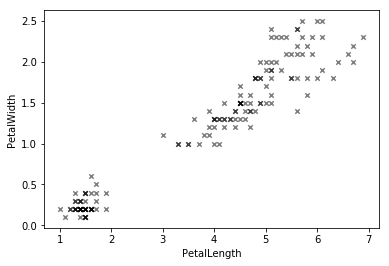

In [3]:
X_train = iris[["PetalLength", "PetalWidth"]]
X_train.plot.scatter(x="PetalLength", y="PetalWidth", 
                     c="black", marker="x", alpha=.5)

# Chapter 7.1 $K$-Means Clustering

$K$-means is an algorithm for finding clusters in data. The idea behind $k$-means is simple: each cluster has a "center" point called the **centroid**, and each observation is associated with the cluster of its nearest centroid. The challenge is finding those centroids. The $k$-means algorithm starts with a random guess for the centroids and iteratively improves them.

The steps are as follows:

1. Initialize $k$ centroids at random.
2. Assign each point to the cluster of its nearest centroid.
3. (After reassignment, each centroid may no longer be at the center of its cluster.) Recompute each centroid based on the points assigned to its cluster.
4. Repeat steps 2 and 3 until no points change clusters.

# Implementing K-Means from Scratch

First, we will implement the $k$-means algorithm from scratch. First, let's sample 3 points at random from the iris data to serve as the initial centroids.

,PetalLength,PetalWidth
r,5.1,2.0
b,5.7,2.3
y,1.5,0.2


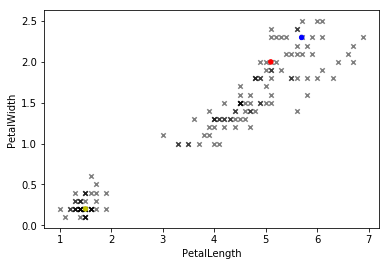

In [4]:
# Initialize 3 centroids at random from the data.
centroids = X_train.sample(3)

# Call the three clusters "red", "blue", "yellow" for convenience.
centroids.index = ["r", "b", "y"]

# Plot these centroids.
ax = X_train.plot.scatter(x="PetalLength", y="PetalWidth", 
                          c="black", marker="x", alpha=.5)
centroids.plot.scatter(x="PetalLength", y="PetalWidth", 
                       c=centroids.index, ax=ax)

centroids

Now we assign each point to the cluster of its nearest centroid.

In [5]:
# Finds the nearest centroid to a given observation.
def get_nearest_centroid(obs):
    dists = np.sqrt(((obs - centroids) ** 2).sum(axis=1))
    return dists.idxmin()

get_nearest_centroid(X_train.loc[0])

'y'

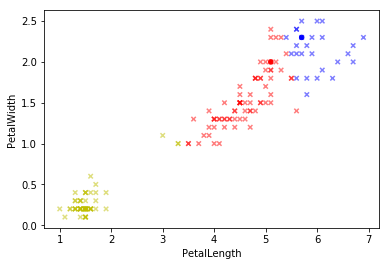

In [6]:
# Apply the function to the entire data set.
clusters = X_train.apply(get_nearest_centroid, axis=1)

# Plot the cluster assignments.
ax = X_train.plot.scatter(x="PetalLength", y="PetalWidth", 
                          c=clusters, marker="x", alpha=.5)
centroids.plot.scatter(x="PetalLength", y="PetalWidth", 
                       c=centroids.index, ax=ax)

Notice that some of the centroids are no longer at the center of their clusters. We can fix that by redefining the centroid to be the mean of the points in its cluster.

,PetalLength,PetalWidth
b,5.965385,2.138462
r,4.590141,1.533803
y,1.562264,0.288679


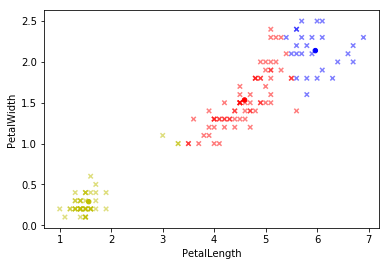

In [7]:
# Calculate the mean length and width for each cluster.
centroids = X_train.groupby(clusters).mean()

# Let's plot the new centroids.
ax = X_train.plot.scatter(x="PetalLength", y="PetalWidth", 
                          c=clusters, marker="x", alpha=.5)
centroids.plot.scatter(x="PetalLength", y="PetalWidth", 
                       c=centroids.index, ax=ax)

centroids

Now, there may be some points that are no longer assigned to their closest centroid, so we have to go back and re-assign clusters. But that may cause the centroids to no longer be at the center of their cluster, so we have to recalculate the centroids. And so on. This process continues until the cluster assignments stop changing.

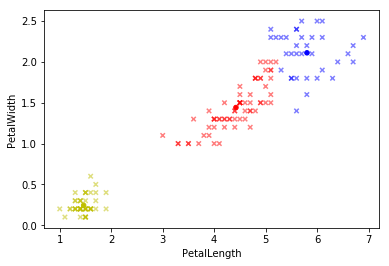

In [8]:
# Assign points to their nearest centroid.
clusters = X_train.apply(get_nearest_centroid, axis=1)

# Recalculate the centroids based on the clusters.
centroids = X_train.groupby(clusters).mean()

# Plot the current cluster assignments and the centroids.
ax = X_train.plot.scatter(x="PetalLength", y="PetalWidth", 
                          c=clusters, marker="x", alpha=.5)
centroids.plot.scatter(x="PetalLength", y="PetalWidth", 
                       c=centroids.index, ax=ax)

We can run the code in the above cell over and over until the clusters stop changing. This is the final cluster assignment.

It is not so easy to visualize the clusters when there are more than 2 features. But we can wrap the same algorithm inside a loop that continues until the cluster assignments do not change from one step to the next. One of the exercises below walks you through such an implementation.

# K-Means in _scikit-learn_

We rarely need to implement the $k$-means algorithm from scratch because it is available in _scikit-learn_. The API for _scikit-learn_'s $k$-means model is similar to the API for supervised learning models, like $k$-nearest neighbors, except that the `.fit()` method only takes in `X`, not `X` and `y`. This makes sense because in unsupervised learning, there are no ground truth labels `y`.

In [9]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
# Extract the centroids and the clusters.
centroids = model.cluster_centers_
clusters = model.labels_

clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

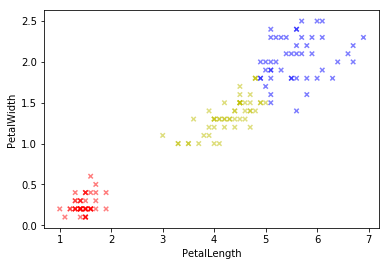

In [11]:
# Map the cluster numbers to colors.
clusters = pd.Series(clusters).map({
    0: "r",
    1: "b",
    2: "y"
})

# Plot the data
X_train.plot.scatter(x="PetalLength", y="PetalWidth", 
                     c=clusters, marker="x", alpha=.5)

We can call `model.predict()` to get the cluster assignment for a new observation. This will simply assign the new observation to the nearest cluster without recalculating the centroids. (If this observation had been in the training data, then assigning the new observation to a cluster would require recalculating the centroid, which would in turn require reassigning observations to clusters, and so on.)

For example, consider a flower whose petal has a length of 5.0 and a width of 0.5. It's obvious which cluster this point should be assigned to. Let's check that this is indeed the case, by calling `.predict()` on our fitted model.

In [12]:
model.predict([[5.0, 0.5]])

array([2], dtype=int32)

## A Note about Standardization

Note that we did not standardize the variables in the example above. Just as with $k$-nearest neighbors, it is generally a good idea to standardize your variables before applying $k$-means. Let's see how different the clusters would be if the variables had been standardized.

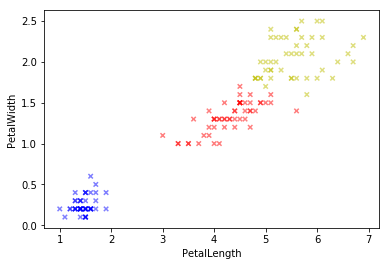

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=3)
model.fit(X_train_std)

clusters = pd.Series(model.labels_).map({
    0: "r",
    1: "b",
    2: "y"
})

X_train.plot.scatter(x="PetalLength", y="PetalWidth", 
                     c=clusters, marker="x", alpha=.5)

Let's compare these clusters to the ones we obtained above, keeping in mind that the coloring of the clusters is arbitrary. (All that matters is which observations are grouped together.) We see that only a handful observations near the boundary actually change cluster.  Standardization turns out not to matter much for the iris dataset because the variables are on similar scales. But in data sets with variables on different scales, standardization is crucial.

# Exercises

**Exercise 1.** Use $k$-means to cluster the wines in the wines dataset into 2 clusters. (Code to read in this dataset has been provided below.) How well do your two clusters correspond to white and red wines? (The way the dataset is read in below, the first 1599 wines are red, and the rest are white.)

_Hint:_ Don't forget to standardize your variables first!

In [41]:
# TYPE YOUR CODE HERE.
red = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/"
                  "master/data/wines/reds.csv", sep=";")
red["color"] = 0
white = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/"
                    "master/data/wines/whites.csv", sep=";")
white["color"] = 1
wines = pd.concat([red, white], ignore_index=True)
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,1


In [42]:
X_train = wines.drop("color", axis=1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=2)
model.fit(X_train_std)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
vc = (model.labels_ == wines["color"]).value_counts()
correct = vc[1]
wrong = vc[0]

In [50]:
correct / (correct + wrong)

0.9816838540865015

**Exercise 2.** Use $k$-means to cluster the Titanic passengers (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv`) into $k$ clusters. You are free to choose the number of clusters $k$ and the features to include (but be sure to include both categorical and quantitative features). Look at the profiles of the passengers in each cluster. Can you come up with an "interpretation" of each cluster based on the passengers in it?

In [29]:
titanic_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv")
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [31]:
X_train = titanic_df[["pclass", "age", "survived"]].dropna()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=12)
model.fit(X_train_std)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

**Exercise 3.** The code below reads in the "two moons" dataset, a synthetic dataset that is used to evaluate clustering algorithms. What should be the two clusters be _intuitively_? What do you think $k$-means will return as the clusters? Once you have a hypothesis, test it out by fitting the model to this dataset and plotting the resulting clusters.

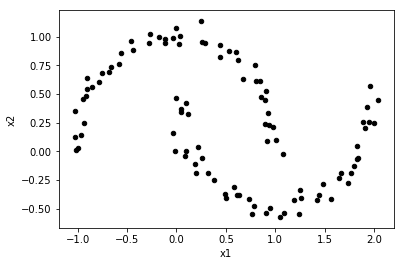

In [51]:
# TYPE YOUR CODE HERE
moons = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/"
                    "master/data/two_moons.csv")
moons.plot.scatter(x="x1", y="x2", color="k")

In [52]:
X_train = moons
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=2)
model.fit(X_train_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

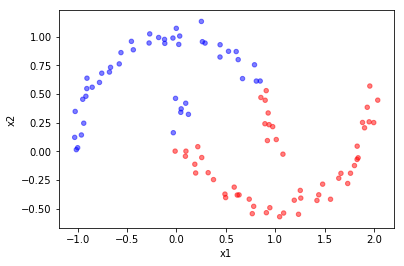

In [35]:
clusters = pd.Series(model.labels_).map({
    0: "r",
    1: "b",
})

X_train.plot.scatter(x="x1", y="x2", 
                     c=clusters, marker="o", alpha=.5)

**Exercise 4.** The code below reads in the "satellite" dataset, a synthetic dataset that is used to evaluate clustering algorithms. What should the two clusters be _intuitively_? What will the clusters be if you ask $k$-means to cluster this data into 2 clusters? Once you have a hypothesis, test it out by running $k$-means on this dataset.

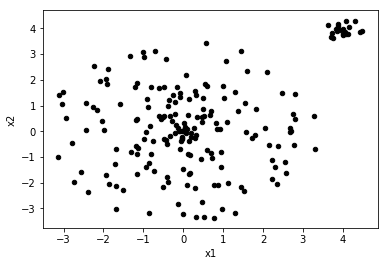

In [36]:
# TYPE YOUR CODE HERE
satellite = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/"
                        "master/data/satellite.csv")
satellite.plot.scatter(x="x1", y="x2", color="k")

In [38]:
X_train = satellite
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=2)
model.fit(X_train_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

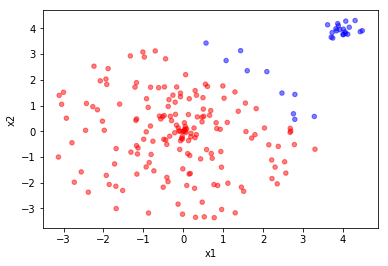

In [39]:
clusters = pd.Series(model.labels_).map({
    0: "r",
    1: "b",
})

X_train.plot.scatter(x="x1", y="x2", 
                     c=clusters, marker="o", alpha=.5)

**Challenge Exercise.** Write a function, `get_kmeans_clusters`, that takes in a `DataFrame` and a number of clusters, and returns a `Series` containing the cluster assignment of each observation (row).

In [ ]:
def get_kmeans_clusters(X_train, k):
    raise NotImplementedError